In [1]:
from scipy.stats import entropy

In [6]:
entropy([0.5,0.5], base=2)

1.0

In [1]:
import json
import infosys.utils as utils 
import igraph as ig
import os
import collections
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pickle as pkl

In [2]:
ABS_PATH = '/N/slate/baotruon/marketplace'
DATA_PATH = '/N/slate/baotruon/marketplace/data'

print(os.getcwd())
exp_configs = json.load(open(os.path.join(DATA_PATH, 'all_configs.json'),'r'))
EXPS = list(exp_configs['vary_thetaphi'].keys()) #keys are name of exp, format: '{targeting}_{thetaidx}{phiidx}' 

# map available network in `vary_targetgamma` corresponding with the exp
# networks from `vary_targetgamma` has format: '{targeting}{gamma}'
GAMMA = [0.0001, 0.0002, 0.0005, 0.001, 0.002, 0.005, 0.02, 0.05, 0.1, 0.2, 0.5]
TARGETING = [None, 'hubs', 'partisanship', 'conservative', 'liberal', 'misinformation']

EXP_NETWORK = {}

gamma = 0.1 # gamma in the range where targeting has some effect
# need to match with default_targeting
for exp in EXPS:
    if 'none' in exp:
        networkname = '%s%s' %(TARGETING.index(None), GAMMA.index(gamma))
    else: 
        networkname = '%s%s' %(TARGETING.index(exp.split('_')[0]), GAMMA.index(gamma) )
    EXP_NETWORK[exp] = networkname

/geode2/home/u010/baotruon/Carbonate/marketplace/exps


In [3]:
exp = 'vary_thetaphi_1runs_gamma0.005'
RES_DIR = os.path.join(ABS_PATH,'results', exp)
TRACKING_DIR = os.path.join(ABS_PATH,'long_results',exp)
NETWORK_PATH = os.path.join(DATA_PATH, 'igraph/vary_targetgamma')

In [4]:
hub_expno = 'hubs_04'
none_expno = 'none_04'

In [5]:
PLOT_DIR = os.path.join(ABS_PATH,'analysis_plots',exp)

In [6]:
hub_expno='hubs_04'
hubnet = os.path.join(NETWORK_PATH, "network_%s.gml" %EXP_NETWORK[hub_expno])
G = ig.Graph.Read_GML(hubnet)
verbose = utils.read_json_compressed(os.path.join(TRACKING_DIR,'%s.json.gz' %hub_expno))

In [7]:
verbose['all_feeds'][0]

{'65537': [348955,
  348829,
  346745,
  67743,
  347998,
  255472,
  348181,
  348099,
  67743,
  347936,
  345262,
  347282,
  344959,
  347114,
  346984],
 '65538': [348960,
  348030,
  348027,
  67743,
  303331,
  34806,
  67743,
  67743,
  346183,
  346027,
  345368,
  345256,
  34806,
  34806,
  344805],
 '5': [67743,
  348776,
  346745,
  348435,
  348387,
  348288,
  67743,
  348030,
  347708,
  67743,
  345262,
  344317,
  347292,
  347054,
  67743],
 '32775': [67743,
  348726,
  67743,
  67743,
  67743,
  67743,
  67743,
  348866,
  67743,
  348871,
  67743,
  348846,
  348838,
  255472,
  67743],
 '98314': [348884,
  348980,
  348952,
  255472,
  303331,
  348561,
  348435,
  34806,
  348355,
  348345,
  303331,
  301606,
  348103,
  348044,
  348027],
 '32780': [349001,
  67743,
  67743,
  348726,
  348453,
  348967,
  255472,
  348973,
  348968,
  67743,
  67743,
  67743,
  348942,
  67743,
  67743],
 '131084': [348977,
  346745,
  348923,
  348853,
  67743,
  348825,
  25

In [8]:
verbose['all_memes'][0]

[{'id': 1,
  'is_by_bot': 0.0,
  'phi': 5,
  'quality': 0.10036026657504726,
  'fitness': 0.10036026657504726,
  'human_shares': 1,
  'bot_shares': 0,
  'spread_via_agents': [6426],
  'qual_th': 165633,
  'share_th': 157337},
 {'id': 2,
  'is_by_bot': 0.0,
  'phi': 5,
  'quality': 0.08848575340757081,
  'fitness': 0.08848575340757081,
  'human_shares': 1,
  'bot_shares': 0,
  'spread_via_agents': [2768],
  'qual_th': 150471,
  'share_th': 143608},
 {'id': 3,
  'is_by_bot': 0.0,
  'phi': 5,
  'quality': 0.05827939751698852,
  'fitness': 0.05827939751698852,
  'human_shares': 3,
  'bot_shares': 0,
  'spread_via_agents': [4701, 38, 8444],
  'qual_th': 107654,
  'share_th': 333629},
 {'id': 4,
  'is_by_bot': 0.0,
  'phi': 5,
  'quality': 0.07161049442233458,
  'fitness': 0.07161049442233458,
  'human_shares': 2,
  'bot_shares': 0,
  'spread_via_agents': [825, 5755],
  'qual_th': 127432,
  'share_th': 311825},
 {'id': 5,
  'is_by_bot': 0.0,
  'phi': 5,
  'quality': 0.06066316797887317,
  'f

## fraction of bot memes

In [34]:
def final_botmeme_fraction(G, verbose):
    # Stat final state
    # Helper for plotting fraction of bot memes vs node in degree
    # Note: feed keys are strings, meme ids and all other keys are ints
    deg_mode='in'

    human_nodes = [int(node['id']) for node in G.vs if node['bot']==0]
    human_agents = [node['uid'] for node in G.vs if node['bot']==0]
    hum_degrees = G.degree(human_nodes, mode=deg_mode, loops=False)

    botmeme_ids = [meme['id'] for meme in verbose['all_memes'][0] if meme['is_by_bot']==1]
#     print(botmeme_ids)
    final_agent_info={}
    for idx, agentid in enumerate(human_agents):
        memeids = verbose['all_feeds'][0][agentid]
        
        if len(memeids)>0:
#             print('MEME ids:')
#             print(memeids)
            bot_num= len([memeid for memeid in memeids if memeid in botmeme_ids])
            assert(bot_num<=len(memeids))

            bot_frac = bot_num/len(memeids)
            final_agent_info[agentid] = {'in_degree': hum_degrees[idx],
                                        'botmeme_frac': bot_frac}

    return final_agent_info

In [35]:
botfrac=final_botmeme_fraction(G, verbose)

In [17]:
none_expno='none_04'
nonenet = os.path.join(NETWORK_PATH, "network_%s.gml" %EXP_NETWORK[none_expno])
G_none = ig.Graph.Read_GML(nonenet)
verbose = utils.read_json_compressed(os.path.join(TRACKING_DIR,'%s.json.gz' %none_expno))

In [36]:
botfrac_none=final_botmeme_fraction(G_none, verbose)

In [48]:
def botmeme_frac_vs_degree(nostrag_info, strag_info, plot_fpath=None, log_x=True):
    figure, ax = plt.subplots()
    
    if log_x is True:
        ax.set_xscale('log')
        
    ax.scatter([info['in_degree'] for info in nostrag_info.values()], 
               [info['botmeme_frac'] for info in nostrag_info.values()], label = 'no targeting', alpha=0.5)
    ax.scatter([info['in_degree'] for info in strag_info.values()], [info['botmeme_frac'] for info in strag_info.values()], label = 'hub targeting', alpha=0.5)
    ax.set_xlabel('Node in-degree')
    ax.legend()
    ax.set_title("Fraction of bot memes in agent's feed vs their in-degree")

    figure.tight_layout()
    if plot_fpath is not None:
        figure.savefig(plot_fpath, dpi=300)
        plt.close(figure)
    else:
        figure.show()


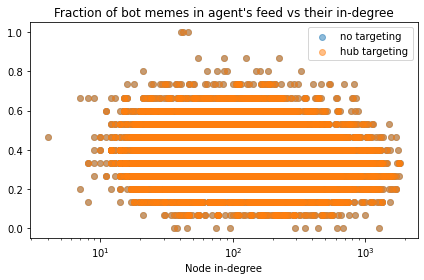

In [49]:
botmeme_frac_vs_degree(botfrac_none, botfrac, plot_fpath=None, log_x=True)

In [50]:
nostrag_frac = [info['botmeme_frac'] for info in botfrac_none.values()]
strag_frac = [info['botmeme_frac'] for info in botfrac.values()]


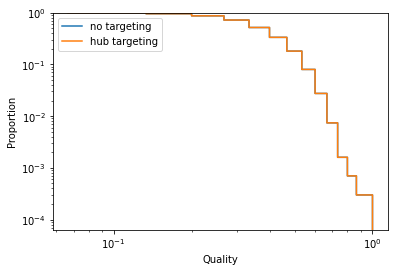

In [54]:
figure, ax = plt.subplots()
sns.ecdfplot(ax=ax, data = nostrag_frac, complementary=True, label = 'no targeting')
sns.ecdfplot(ax=ax, data = strag_frac, complementary=True, label = 'hub targeting')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Quality')
ax.legend()

(array([1.200e+02, 3.780e+02, 2.331e+03, 2.023e+03, 3.344e+03, 1.527e+03,
        2.000e+02, 5.800e+01, 1.300e+01, 3.000e+00]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

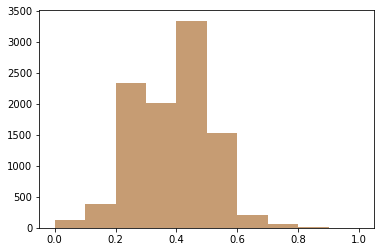

In [53]:
plt.hist(nostrag_frac, label = 'no targeting', alpha=0.5)
plt.hist(strag_frac, label = 'targeting', alpha=0.5)

## entropy

In [55]:
from scipy.special import entr

In [58]:
def final_entropy(verbose_tracking, base=2, verbose=True):
    # Get entropy of the system from the distribution of probability that a feed contains a bot meme. 

    bot_frac = []
    zero_len_feed=0
    botmeme_ids = [meme['id'] for meme in verbose_tracking['all_memes'][0] if meme['is_by_bot']==1]

    for agentid, memeids in verbose_tracking['all_feeds'][0].items():
        if any(map(str.isalpha, agentid)) is True:
            #skip bots
            continue
        
        if len(memeids)<=0:
            zero_len_feed +=1

        else:
            bot_num= len([memeid for memeid in memeids if memeid in botmeme_ids])
            assert(bot_num<=len(memeids))

            bot_frac += [bot_num/len(memeids)]
    print(bot_frac)
    # system_entropy = entropy(bot_frac, base=base)
    system_entropy = entr(bot_frac).sum() #use special.entr instead of stats.entropy() because the latter normalize the probs

    if verbose is True:
        logger.info('Zero-length feed: %s/%s' %(zero_len_feed, len(verbose_tracking['all_feeds'][0])))
        logger.info('Entropy: %s' %system_entropy)

    return system_entropy

In [59]:
final_entropy(verbose)

[0.3333333333333333, 0.26666666666666666, 0.5333333333333333, 0.13333333333333333, 0.4666666666666667, 0.4, 0.3333333333333333, 0.6, 0.26666666666666666, 0.4666666666666667, 0.4, 0.6, 0.3333333333333333, 0.13333333333333333, 0.2, 0.26666666666666666, 0.4, 0.6666666666666666, 0.7333333333333333, 0.13333333333333333, 0.26666666666666666, 0.4, 0.4666666666666667, 0.4, 0.4, 0.4666666666666667, 0.4, 0.2, 0.3333333333333333, 0.4666666666666667, 0.4, 0.2, 0.26666666666666666, 0.5333333333333333, 0.2, 0.4, 0.26666666666666666, 0.4, 0.3333333333333333, 0.3333333333333333, 0.4666666666666667, 0.5333333333333333, 0.4, 0.4, 0.26666666666666666, 0.3333333333333333, 0.3333333333333333, 0.5333333333333333, 0.4, 0.26666666666666666, 0.4666666666666667, 0.4666666666666667, 0.4666666666666667, 0.5333333333333333, 0.5333333333333333, 0.3333333333333333, 0.4666666666666667, 0.6666666666666666, 0.2, 0.4666666666666667, 0.6, 0.5333333333333333, 0.3333333333333333, 0.5333333333333333, 0.4666666666666667, 0.2

NameError: name 'logger' is not defined